<a href="https://colab.research.google.com/github/Laofin050/Machine-Learning-Project-2018-049-2018-050/blob/main/Deployment_app_with_Heroku_and_Flask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Soal Praktikum Overfitting Handling #2**

## Kegiatan 1 **(Individu)** 
70 poin

**Peraturan :**
* Tidak boleh ada error dalam kode program
* Dalam modul ini tidak diperbolehkan menggunakan teknik transfer learning dari pretrain model baik yang di bangun sendiri atau anda dapatkan dari sumber lain (tensorflow, keras, dan sebagainya)
* Perhatikan langkah demi langkah yang diperintahkan dalam kegiatan ini

### **SOAL 1 :** 
---
Dalam mendefinisikan model Machine Learing ada banyak cara untuk mendapatkan model dengan performa terbaik salah satunya adalah hyperparameter tuning. Contoh hyperparameter tuning telah diberikan dalam materi di modul ini, dalam kegiatan ini telah diberikan sedikit contoh lain untuk mendefinisikan model hyperparameter tuning dengan hparam. **Tugas anda dalam kegiatan modul kali ini adalah membuat model CNN dengan hyperparameter tuning dengan ketentuan wajib sebagai berikut :**
* Menerapkan materi dari modul-modul sebelumnya (modul 2 dan 3)
* **Menggunakan image disease dataset (bebas dari sumber mana saja)**
* Menggunakan dataset dengan jumlah minimal 5000 data
* Lakukan eksperimen model untuk mencari model CNN dengan performa terbaik untuk mengklasifikasikan dataset yang anda gunakan.
* Definisikan minimal 2 model CNN dengan komposisi parameter yang berbeda-beda.
* Masing-masing model memiliki **minimal** 50 epoch.
* Dalam mendefinisikan model, WAJIB melakukan tuning minimal pada 3 parameter model yang dirubah misalnya merubah jumlah neuron, nilai dropout, nilai lerning rate, jenis optimizer, jenis activation function dsb.
* Visualisasikan hasil evaluasi performa model. Anda dapat menggunakan plot pada umumnya seperti grafik loss dan accuracy dengan matplotib atau visualisasi interaktif menggunakan tensorboard seperti pada contoh dibawah.



In [1]:
# Tulis Program Anda Disini!

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Disease"

In [3]:
%cd /content/drive/My Drive/Disease

/content/drive/My Drive/Disease


In [4]:
ls

chest_xray/  Data/  kaggle.json  Test/  Train/  Valid/


In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:27<00:00, 52.4MB/s]
100% 2.29G/2.29G [00:27<00:00, 89.5MB/s]


In [7]:
!unzip \*.zip &> /dev/null && rm *.zip

In [8]:
ls

chest_xray/  kaggle.json


In [9]:
from os import mkdir

mkdir ('Data')

In [10]:
import shutil,sys

shutil.move("/content/drive/My Drive/Disease/chest_xray/train/NORMAL", "/content/drive/My Drive/Disease/Data")
shutil.move("/content/drive/My Drive/Disease/chest_xray/train/PNEUMONIA", "/content/drive/My Drive/Disease/Data")

'/content/drive/My Drive/Disease/Data/PNEUMONIA'

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [6]:
%rm -rf Test/
%rm -rf Train/
%rm -rf Valid/

In [7]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/drive/My Drive/Disease/Train/"
VALID_DIR ="/content/drive/My Drive/Disease/Valid/"
TEST_DIR ="/content/drive/My Drive/Disease/Test/"

os.mkdir(TRAIN_DIR)
os.mkdir(VALID_DIR)
os.mkdir(TEST_DIR)

for label in ['NORMAL', 'PNEUMONIA']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(VALID_DIR+label)
    os.mkdir(TEST_DIR+label)

In [8]:
import random

def train_valid_test_split(source, train_dir, valid_dir, test_dir,train_size, valid_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-(valid_size + train_size)))
    valid_size = int(len(files) * (1-(valid_size + test_size)))
    test_size = int(len(files) * (1-train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:valid_size]
    valid_set = shuffled_files[valid_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)
        
    for filename in valid_set:
        filepath = source + filename
        destination = valid_dir + filename
        copyfile(filepath, destination)
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/drive/My Drive/Disease/Data/"

for label in ['NORMAL', 'PNEUMONIA']:
    print(label)
    train_valid_test_split(SOURCE+label+'/',  TRAIN_DIR +label+'/', VALID_DIR +label+'/', TEST_DIR +label+'/', train_size=0.8, valid_size=0.19, test_size=0.01)
    print('Total images: ', len(os.listdir(SOURCE +label+'/')))
    print('Training: ', len(os.listdir(TRAIN_DIR +label+'/')))
    print('Validation: ', len(os.listdir(VALID_DIR +label+'/')))
    print('Testing: ', len(os.listdir(TEST_DIR +label+'/')))
    print()

NORMAL
Total images:  1341
Training:  1059
Validation:  269
Testing:  13

PNEUMONIA
Total images:  3875
Training:  3062
Validation:  775
Testing:  38



In [12]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [13]:
train = get_training_data('/content/drive/My Drive/Disease/Train')
test = get_training_data('/content/drive/My Drive/Disease/Test')
val = get_training_data('/content/drive/My Drive/Disease/Valid')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


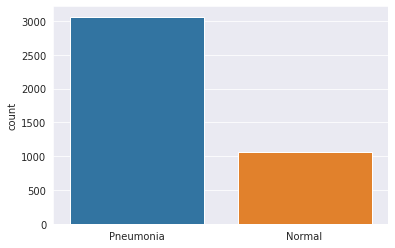

In [14]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)   

Text(0.5, 1.0, 'NORMAL')

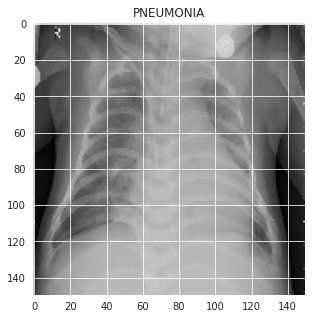

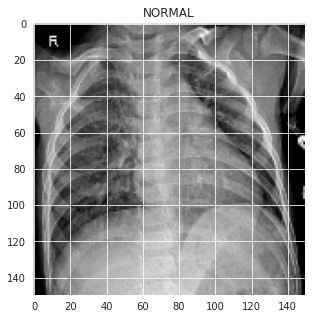

In [17]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [15]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [16]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [17]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [20]:
datagen2 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_val)

In [21]:
train_images = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
val_images = datagen2.flow_from_directory(
    VALID_DIR,
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset = 'training'
)

test_images = datagen2.flow_from_directory(
    TEST_DIR,
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset = 'validation'
)

Found 4121 images belonging to 2 classes.
Found 1044 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


**MODELLING**

In [33]:
# Model 1
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.15))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 164 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "SGD" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [34]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.001)

In [35]:
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32) ,
                    epochs = 50 , validation_data = datagen2.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/50
129/129 [==============================] - 16s 112ms/step - loss: 0.3499 - accuracy: 0.8627 - val_loss: 1.0960 - val_accuracy: 0.7423 - lr: 0.0100
Epoch 2/50
129/129 [==============================] - 14s 109ms/step - loss: 0.2171 - accuracy: 0.9119 - val_loss: 2.1811 - val_accuracy: 0.7423 - lr: 0.0100
Epoch 3/50
129/129 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9223
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
129/129 [==============================] - 14s 108ms/step - loss: 0.1923 - accuracy: 0.9223 - val_loss: 2.6125 - val_accuracy: 0.7423 - lr: 0.0100
Epoch 4/50
129/129 [==============================] - 14s 108ms/step - loss: 0.1727 - accuracy: 0.9323 - val_loss: 1.6434 - val_accuracy: 0.7423 - lr: 0.0030
Epoch 5/50
129/129 [==============================] - 14s 108ms/step - loss: 0.1666 - accuracy: 0.9350 - val_loss: 0.5152 - val_accuracy: 0.8065 - lr: 0.0030
Epoch 6/50
129/129 [=========================

In [37]:
print ("Loss - ", model.evaluate(x_train, y_train)[0])
print ("Accuracy - ", model.evaluate(x_train, y_train)[1]*100, "%")

129/129 [==============================] - 3s 24ms/step - loss: 0.1440 - accuracy: 0.9432
Loss -  0.14396707713603973
129/129 [==============================] - 3s 23ms/step - loss: 0.1440 - accuracy: 0.9432
Accuracy -  94.32176947593689 %


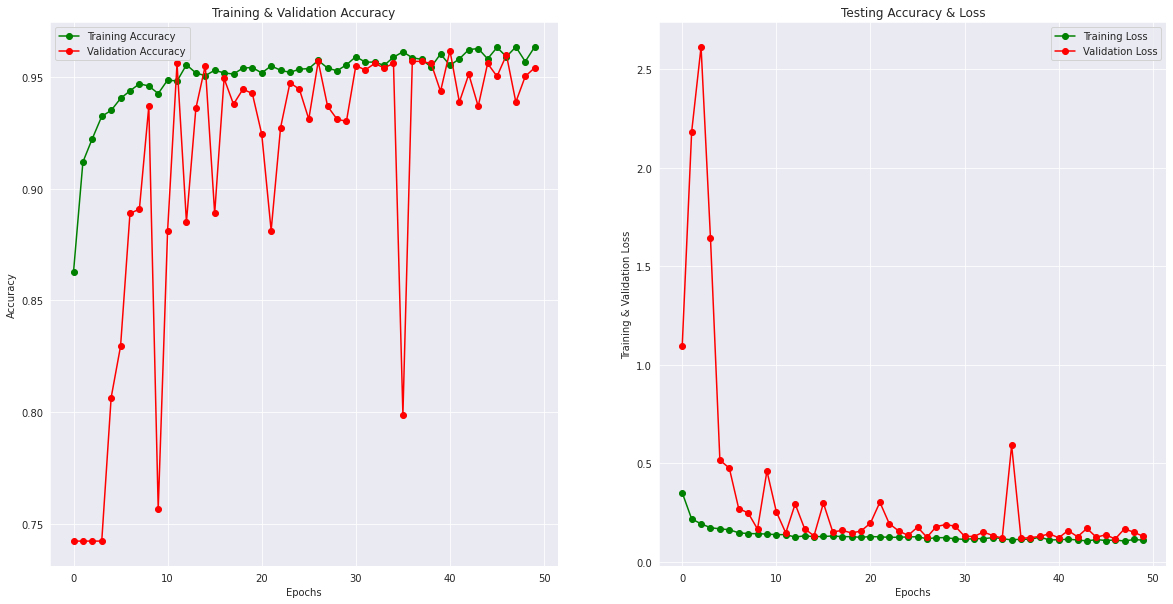

In [39]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [43]:
predictions = (model.predict(x_train) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:15]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [45]:
print(classification_report(y_train, predictions, target_names = ['Pneumonia','Normal']))

              precision    recall  f1-score   support

   Pneumonia       0.99      0.93      0.96      3062
      Normal       0.83      0.98      0.90      1059

    accuracy                           0.94      4121
   macro avg       0.91      0.95      0.93      4121
weighted avg       0.95      0.94      0.94      4121



In [47]:
cm = confusion_matrix(y_train,predictions)
cm

array([[2852,  210],
       [  24, 1035]])

In [48]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

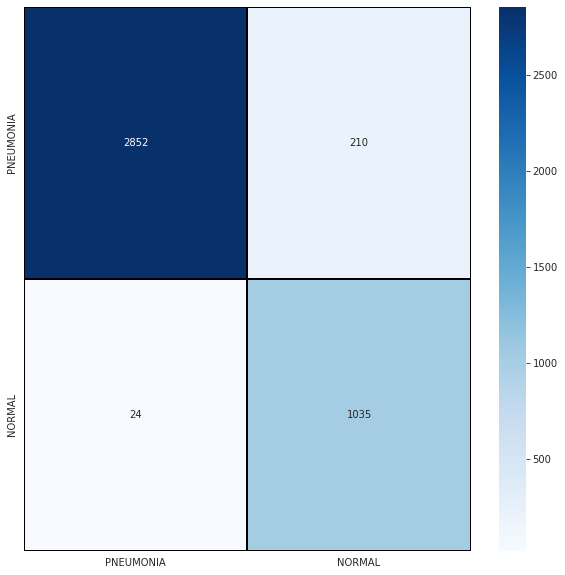

In [49]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [50]:
correct = np.nonzero(predictions == y_train)[0]
incorrect = np.nonzero(predictions != y_train)[0]

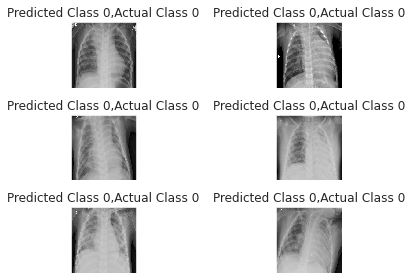

In [52]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_train[c]))
    plt.tight_layout()
    i += 1